# Springboard--DSC Program

# Capstone Project 1 - Regression
### by Ellen A. Savoye

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import packages and data


In [ ]:
# !pip install wordcloud
# !pip install kaggle
# !pip install spacy
# !pip install swifter
# !pip install tqdm
!pip install -U git+https://github.com/scikit-learn-contrib/imbalanced-learn.git

  Cloning https://github.com/scikit-learn-contrib/imbalanced-learn.git to /tmp/pip-req-build-ts802_sf
  Running command git clone -q https://github.com/scikit-learn-contrib/imbalanced-learn.git /tmp/pip-req-build-ts802_sf
     |████████████████████████████████| 6.9MB 2.7MB/s 
  Created wheel for imbalanced-learn: filename=imbalanced_learn-0.7.0-cp36-none-any.whl size=167059 sha256=79f9e9c979616c4f7f443393e9912ae3f39b1fd425bfcaa169893f16de653c13
  Stored in directory: /tmp/pip-ephem-wheel-cache-toii38po/wheels/6c/07/cf/38cb9b7cc9e6a0ac7648a80ec192b6f2d863405fb0049ac0ff
Successfully built imbalanced-learn
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [ ]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter

# libraries for NLP
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report
from six.moves import range
import scipy.sparse

# for imbalanced datasets
import imblearn
from imblearn.over_sampling import SMOTE

# libraries for getting and moving data
import os
from os import path
import shutil
from zipfile import ZipFile

# for Images
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# set seed
np.random.seed(42)

In [ ]:
# Set directories
# Google Colab
src = "/content/drive/My Drive/DS-Capstone_1/Code/"
dst = "/content/drive/My Drive/DS-Capstone_1/Data/"

# Local computer
# src = "C:\\Users\\ellen\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Code\\"
# dst = "C:\\Users\\ellen\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Data\\"

# Work computer
# src = "C:\\Users\\esavoye\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Code\\"
# dst = "C:\\Users\\esavoye\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Data\\"

# Computer path
# unpickled_df = pd.read_pickle(dst + '/full_data_w_features.pkl')
# unpickled_df_slimmed = pd.read_pickle(dst + '/slimmed_data_w_features.pkl')

# Colab path
unpickled_df = pd.read_pickle(dst + 'full_data_w_features.pkl')
unpickled_df_slimmed = pd.read_pickle(dst + 'slimmed_data_w_features.pkl')


# Test Set & Countvectorizer


Both logistic regression and naive bayes take an X and y input. After applying countvectorizer, the data is split into train and test sets. I'm using stratify to keep the split given that only 8% of the data is labelled as toxic. Without using stratify, the imbalance in my data has the potential to be even worse. 

In [ ]:
# grab text field
cleaned_text = unpickled_df.clean_text

In [ ]:
# create an object of class - Count_Vectorizer
vectorizer = CountVectorizer()

In [ ]:
# call `fit_transform` to build the vocabulary and to convert text to a bag of words
x = vectorizer.fit_transform(cleaned_text)
type(x)

scipy.sparse.csr.csr_matrix

In [ ]:
# Inputs:
#         critics: a Pandas dataframe that contains the dataset.
#         In particular, this dataframe is expected to have a column 
#         called 'quote', and critics.quote is a Series containing
#         all documents, which is this case are movie reviews.
#
#         vectorizer: is expected to be an object of a class from
#         sklearn.feature_extraction.text, (*)
#         or None, in which case, per the code below, is constructed
#         according to class CountVectorizer.
#
# Outputs:
#         X: document-term matrix associated with critics.quote,
#         according to the vectorization implemented by object 
#         vectorizer.
#
#         y: this is the label vector, such that y[i] is the label
#         associated with document i, encoded according to row i of X
#
#         vectorizer: vectorizer_object object built
#**************************************************************************
def make_xy(unpickled_df, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(unpickled_df.clean_text)
    X = X.tocsc()
    y = (unpickled_df.target_binary == 1).values.astype(np.int)
    return X, y, vectorizer

X, y, vectorizer = make_xy(unpickled_df)

In [ ]:
# # Create file for use in the future 
# scipy.sparse.save_npz(dst + '/X.pkl', X)
# np.save(dst + '/y.npy', y)

In [ ]:
# load files for use in the future 
X = scipy.sparse.load_npz(dst + 'X.pkl.npz')
y = np.load(dst + 'y.npy')

In [ ]:
counter = Counter(y)
print(counter)

Counter({0: 1660540, 1: 144334})


# Over-Sampling

Previously, I ran a logistic regression and Naive Bayes model for my baseline. Given the imbalanced nature of my data, I'd like to see how the results fare for both logistic regression and Naive Bayes using over-sampling (SMOTE) where both toxic and non-toxic values have the same count.

In [ ]:
# load files for use in the future 
X_resample = scipy.sparse.load_npz(dst + 'X_resample.pkl.npz')
y_resample = np.load(dst + 'y_resample.npy')

In [ ]:
# create x and y split for train and test sets 

Xtrain, Xtest, ytrain, ytest = train_test_split(X_resample, y_resample, stratify=y_resample)

In [ ]:
# oversample = SMOTE()
X_resample, y_resample = oversample.fit_resample(X, y)

In [ ]:
# # Create file for use in the future 
# scipy.sparse.save_npz(dst + '/X_resample.pkl', X_resample)
# np.save(dst + '/y_resample.npy', y_resample)

In [ ]:
counter = Counter(y_resample)
print(counter)

Counter({0: 1660540, 1: 1660540})


# Logistic Regression - Post SMOTE

In [ ]:
# Construct the LogisticRegression model
clf = LogisticRegression()

# Fit the model on the trainng data.
clf.fit(Xtrain, ytrain)

# Print the accuracy from the testing data.
y_predict_test = clf.predict(Xtest)
print("\n")
print("[Test] Accuracy score (y_predict_test, ytest):",accuracy_score(y_predict_test, ytest))

print("\n")
print("[Test] Accuracy score: (ytest, y_predict_test)",accuracy_score(ytest, y_predict_test))

y_predict_training = clf.predict(Xtrain)
print("\n")
print("[Training] Accuracy score: (ytrain, y_predict_training)",accuracy_score(ytrain, y_predict_training))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)




[Test] Accuracy score (y_predict_test, ytest): 0.92911823864526


[Test] Accuracy score: (ytest, y_predict_test) 0.92911823864526


[Training] Accuracy score: (ytrain, y_predict_training) 0.9311669697809146


In [ ]:
# more comprehensive performance analysis

target_names = ['Non-Toxic', 'Toxic']

print("[Training Classification Report]")
print(classification_report(ytrain, y_predict_training, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(ytest, y_predict_test, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

   Non-Toxic       0.95      0.91      0.93   1245405
       Toxic       0.91      0.95      0.93   1245405

    accuracy                           0.93   2490810
   macro avg       0.93      0.93      0.93   2490810
weighted avg       0.93      0.93      0.93   2490810

[Test Classification Report]
              precision    recall  f1-score   support

   Non-Toxic       0.95      0.91      0.93    415135
       Toxic       0.91      0.95      0.93    415135

    accuracy                           0.93    830270
   macro avg       0.93      0.93      0.93    830270
weighted avg       0.93      0.93      0.93    830270



During the baseline run, the train dataset for non-toxic classification fared very well with precision and recall at 96% and 99% respectively. Train dataset for toxic classification fared poorly with precision and recall at 76% and 49% respectively. The test set had similar numbers.

When applying SMOTE, the toxic classification, for both train and test, drastically increase to 91% and 95% for precision and recall respectively. Average precision and average recall is 93%.

# Naive Bayes

In [ ]:
# multinomial naive bayes classifier
nBayes = MultinomialNB()

# same X and y used for logistic regression
clf_nBayes = nBayes.fit(Xtrain, ytrain)

accuracy_train = nBayes.score(Xtrain,ytrain)
accuracy_test = nBayes.score(Xtest,ytest)

print('The training accuracy is %f and the test accuracy is %f' %(accuracy_train, accuracy_test))

The training accuracy is 0.911537 and the test accuracy is 0.907103


The gap between training and test accuracy does not imply overfitting.

In [ ]:

# Print the accuracy from the testing data.
y_predict_test = clf_nBayes.predict(Xtest)
print("\n")
print("[Test] Accuracy score (y_predict_test, ytest):",accuracy_score(y_predict_test, ytest))

print("\n")
print("[Test] Accuracy score: (ytest, y_predict_test)",accuracy_score(ytest, y_predict_test))

y_predict_training = clf_nBayes.predict(Xtrain)
print("\n")
print("[Training] Accuracy score: (ytrain, y_predict_training)",accuracy_score(ytrain, y_predict_training))




[Test] Accuracy score (y_predict_test, ytest): 0.9071025088224313


[Test] Accuracy score: (ytest, y_predict_test) 0.9071025088224313


[Training] Accuracy score: (ytrain, y_predict_training) 0.9115368093110273


In [ ]:
# more comprehensive performance analysis for NB

target_names = ['Non-Toxic', 'Toxic']

print("[Training Classification Report]")
print(classification_report(ytrain, y_predict_training, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(ytest, y_predict_test, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

   Non-Toxic       0.89      0.93      0.91   1245405
       Toxic       0.93      0.89      0.91   1245405

    accuracy                           0.91   2490810
   macro avg       0.91      0.91      0.91   2490810
weighted avg       0.91      0.91      0.91   2490810

[Test Classification Report]
              precision    recall  f1-score   support

   Non-Toxic       0.89      0.93      0.91    415135
       Toxic       0.92      0.89      0.91    415135

    accuracy                           0.91    830270
   macro avg       0.91      0.91      0.91    830270
weighted avg       0.91      0.91      0.91    830270



In a similar manner to the logistic regression results, the toxic classification for both the train and test set increased drastically. The precision of the train and test set for non-toxic classification descreased a little. However, given the increase for toxic classification, the trade off seems worth it.

In [ ]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(ytrain, y_predict_training)

In [ ]:
# calculate AUC
auc = roc_auc_score(ytrain, y_predict_training)
print('AUC: %.3f' % auc)

AUC: 0.810


No handles with labels found to put in legend.


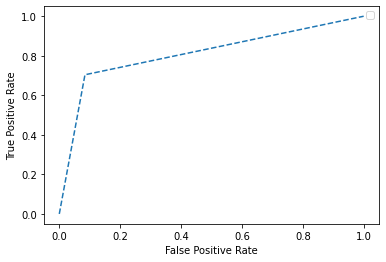

In [ ]:
# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

A good measure of separability implying an excellent model is an AUC near 1. When AUC is 0.5, it means model has no class separation capacity whatsoever. Given an AUC of 0.81, it means there is 81% chance that model will be able to distinguish between positive class (toxic) and negative class (non-toxic). The AUC of 0.81 is the same as the baseline model.
